In [6]:
import os
import sqlite3
import pprint
from datetime import datetime
import ast
import numpy as np
import pandas as pd 

date_format = "%Y-%m-%d %H:%M:%S.%f"
failure_list = ["dependency", "divide_zero", "environment", "memory", "ulimit"]

def get_failure_type(workflow_cnt, repeat=5):
    i = workflow_cnt//repeat
    if i >= len(failure_list):
        return "unknown"
    else:
        return failure_list[i]
    
def sorted_walk(top):
    for root, dirs, files in os.walk(top):
        dirs.sort()
        yield root, dirs, files

def find_and_process_stderr_files(root_directory):
    for root, _, files in os.walk(root_directory):
        aggregated_data = []

        for file in files:
            if file.endswith('stderr'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    for line in f:
                        if 'aggregated_dic' in line:
                            try:
                                # extract aggregated_dic
                                start_index = line.index('aggregated_dic =') + len('aggregated_dic =')
                                dict_str = line[start_index:].strip()
                                aggregated_dic = ast.literal_eval(dict_str)
                                aggregated_data.append(aggregated_dic)
                            except (ValueError, SyntaxError):
                                continue
        
        if aggregated_data:
            # calculate mean
            keys = aggregated_data[0].keys()
            avg_data = {key: np.mean([d[key] for d in aggregated_data if isinstance(d[key], (int, float))]) for key in keys if isinstance(aggregated_data[0][key], (int, float))}
            return avg_data


def process_workflow(runs_directory):
    workflow_list = []
    
    for root, dirs, files in sorted_walk(runs_directory):
        if 'monitoring.db' in files:
            info = {}
            db_path = os.path.join(root, 'monitoring.db')
            try:
                conn = sqlite3.connect(db_path)
                cursor = conn.cursor()

                info['db_dir'] = db_path

                # get run_id
                cursor.execute("SELECT run_id FROM workflow")
                rows = cursor.fetchall()
                info['run_id'] = rows[0][0]

                # get failure type
                info['failure_type'] = get_failure_type(len(workflow_list))

                # get success or not
                cursor.execute("SELECT task_fail_history FROM try WHERE task_id IS 5")
                rows = cursor.fetchall()
                info['success'] = False
                if len(rows) > 0:
                    for row in rows:
                        if row[0] == "":
                            info['success'] = True
                            break

                # get resource dict
                script_path = os.path.join(root, dirs[0], 'submit_scripts')
                info['resource_dict'] = find_and_process_stderr_files(script_path)
                
                conn.close()
            except sqlite3.Error as e:
                print(f"Error reading {db_path}: {e}")
            finally:
                workflow_list.append(info)
    
    return workflow_list


In [7]:
plain_list = process_workflow('without')
plain_df = pd.DataFrame(plain_list)
plain_df

,db_dir,run_id,failure_type,success,resource_dict
0,without/failure-injection-2024-05-31-08-20-34/...,d299ad10-d05d-4181-bf3f-56a35fb887a1,dependency,False,{'psutil_process_memory_percent': 1.8785819382...
1,without/failure-injection-2024-05-31-08-21-41/...,983e9026-9eab-4da4-ac4e-91d3f4da38b6,dependency,False,{'psutil_process_memory_percent': 1.8703325952...
2,without/failure-injection-2024-05-31-08-22-56/...,ac5de11f-b6ef-4fd2-8fcf-31f9f070037f,dependency,False,{'psutil_process_memory_percent': 1.8778567768...
3,without/failure-injection-2024-05-31-08-24-13/...,08b9e37b-4d00-491b-bbf9-4a1be5db02fc,dependency,False,{'psutil_process_memory_percent': 1.8731095992...
4,without/failure-injection-2024-05-31-08-26-16/...,5153bbe1-be97-4411-8262-16116750dea4,dependency,False,{'psutil_process_memory_percent': 1.8845790060...
5,without/failure-injection-2024-05-31-08-28-00/...,6659d502-53ed-40de-9c40-f2d1dad63b7e,divide_zero,False,{'psutil_process_memory_percent': 1.9000386237...
6,without/failure-injection-2024-05-31-08-30-13/...,f6a97a0a-2086-4869-bd68-f7a5c0f5302f,divide_zero,False,{'psutil_process_memory_percent': 1.8767184630...
7,without/failure-injection-2024-05-31-08-32-14/...,501ad88d-890f-4817-b530-0b4d02bff2ca,divide_zero,False,{'psutil_process_memory_percent': 1.8740373632...
8,without/failure-injection-2024-05-31-08-33-40/...,4edc50b3-83b8-4210-8cbd-4420d1f3f353,divide_zero,False,{'psutil_process_memory_percent': 1.9072715787...
9,without/failure-injection-2024-05-31-08-35-13/...,a308808d-c01f-453f-92fa-67df2e919265,divide_zero,False,{'psutil_process_memory_percent': 1.8720905469...


In [8]:
retry_list = process_workflow('with')
retry_df = pd.DataFrame(retry_list)
retry_df

,db_dir,run_id,failure_type,success,resource_dict
0,with/failure-injection-2024-05-31-07-49-55/par...,855db7da-d0c1-4be9-8d77-8b33db366785,dependency,False,{'psutil_process_memory_percent': 1.8178354560...
1,with/failure-injection-2024-05-31-07-50-24/par...,bddfd2f2-58d1-4949-8ac6-bdfea10e8d1b,dependency,False,{'psutil_process_memory_percent': 1.8108690521...
2,with/failure-injection-2024-05-31-07-50-53/par...,495d84a1-65cc-4f26-b433-93b983b5a0da,dependency,False,{'psutil_process_memory_percent': 1.8170291311...
3,with/failure-injection-2024-05-31-07-51-25/par...,5bfdc4db-bb5a-4534-9c38-5446a32bc570,dependency,False,{'psutil_process_memory_percent': 1.8139896734...
4,with/failure-injection-2024-05-31-07-51-53/par...,ec3ad262-1e09-4604-b9a5-c0327f995072,dependency,False,{'psutil_process_memory_percent': 1.8187107984...
5,with/failure-injection-2024-05-31-07-52-25/par...,3930ffbc-28d6-4f8e-b250-d6a5d79391eb,divide_zero,False,{'psutil_process_memory_percent': 1.8069086545...
6,with/failure-injection-2024-05-31-07-54-08/par...,bd66769f-bae5-47e1-a651-eb44b24818ad,divide_zero,False,{'psutil_process_memory_percent': 1.8199824101...
7,with/failure-injection-2024-05-31-07-55-17/par...,9bcaf1f3-161b-4f6e-b146-3083b5ea9ddf,divide_zero,False,{'psutil_process_memory_percent': 1.8014123859...
8,with/failure-injection-2024-05-31-07-55-49/par...,166b7612-cebb-4685-8276-62b208f48c62,divide_zero,False,{'psutil_process_memory_percent': 1.8248160478...
9,with/failure-injection-2024-05-31-07-56-26/par...,c086f253-c45e-4239-b117-e052e595ecdd,divide_zero,False,{'psutil_process_memory_percent': 1.7980073132...


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def draw_resource(resource_type):
    # 确保 'resource_dict' 被展开为独立列
    plain_df_filtered = plain_df[plain_df['resource_dict'].notnull()]
    retry_df_filtered = retry_df[retry_df['resource_dict'].notnull()]
    plain_df_expanded = plain_df_filtered['resource_dict'].apply(pd.Series)
    retry_df_expanded = retry_df_filtered['resource_dict'].apply(pd.Series)

    # 计算均值和方差
    stats_df1 = plain_df_expanded.groupby(plain_df['failure_type'])[resource_type].agg(['mean', 'std']).reset_index()
    stats_df2 = retry_df_expanded.groupby(retry_df['failure_type'])[resource_type].agg(['mean', 'std']).reset_index()

    # 合并两个DataFrame
    merged_stats = pd.merge(stats_df1, stats_df2, on='failure_type', suffixes=('_df1', '_df2'))

    # 设置柱状图位置
    x = np.arange(len(merged_stats['failure_type']))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制df1的柱状图
    rects1 = ax.bar(x - width/2, merged_stats['mean_df1'], width, yerr=merged_stats['std_df1'], label='plain_retry', color='skyblue')

    # 绘制df2的柱状图
    rects2 = ax.bar(x + width/2, merged_stats['mean_df2'], width, yerr=merged_stats['std_df2'], label='resilience', color='lightgreen')

    # 添加一些文本用于标签、标题和自定义x轴刻度
    ax.set_xlabel('Failure Type')
    ax.set_ylabel(resource_type)
    ax.set_title('Mean and Std of Total Time by Failure Type')
    ax.set_xticks(x)
    ax.set_xticklabels(merged_stats['failure_type'])
    ax.legend()

    # 自动调整标签
    fig.tight_layout()

    # 显示图形
    plt.show()


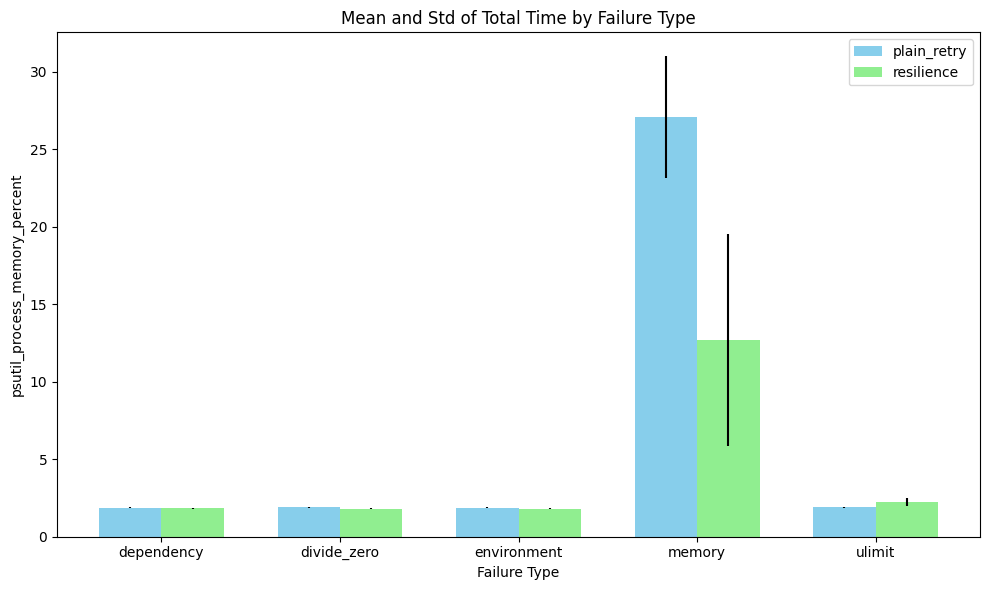

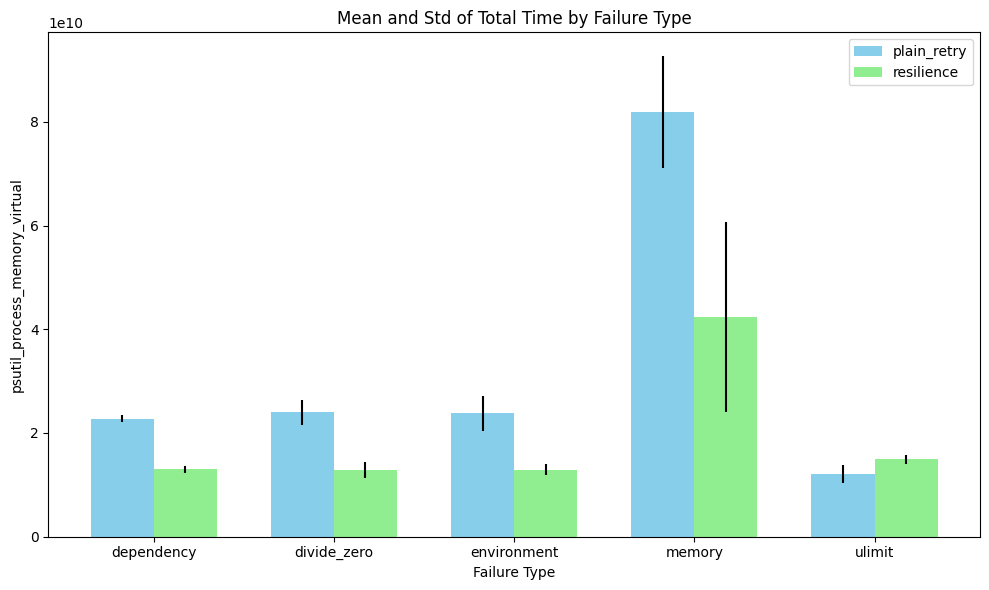

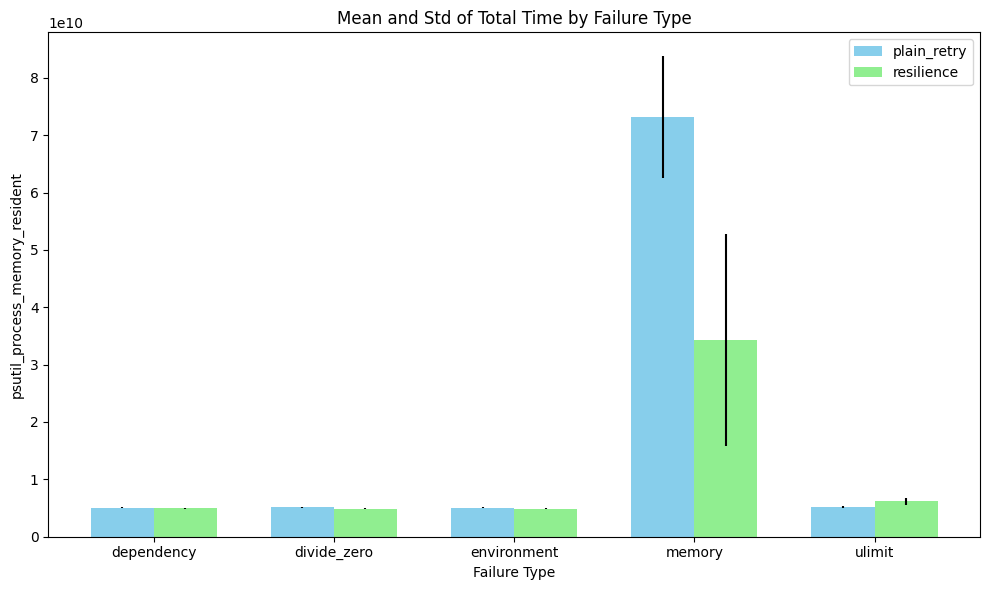

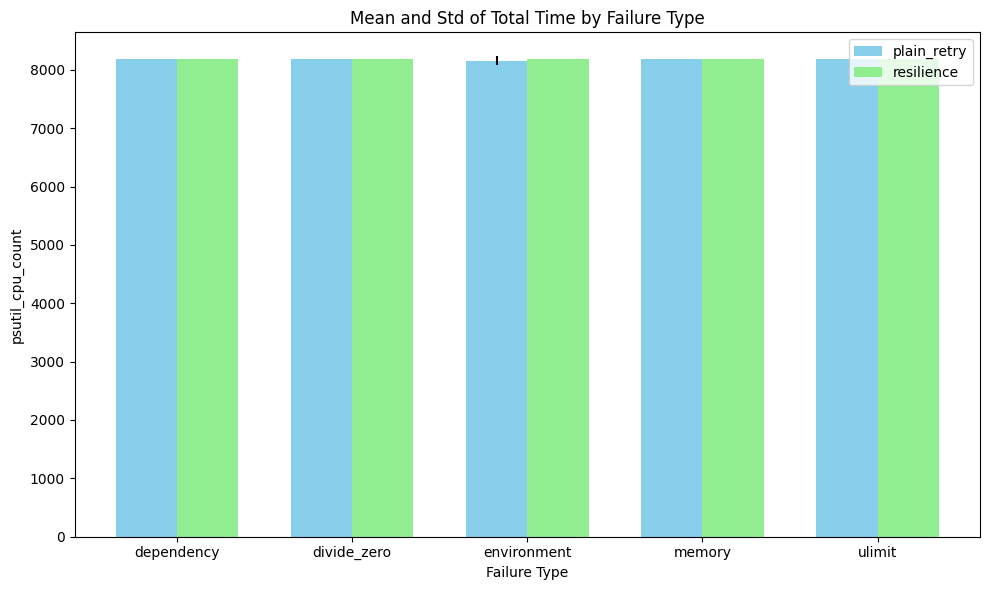

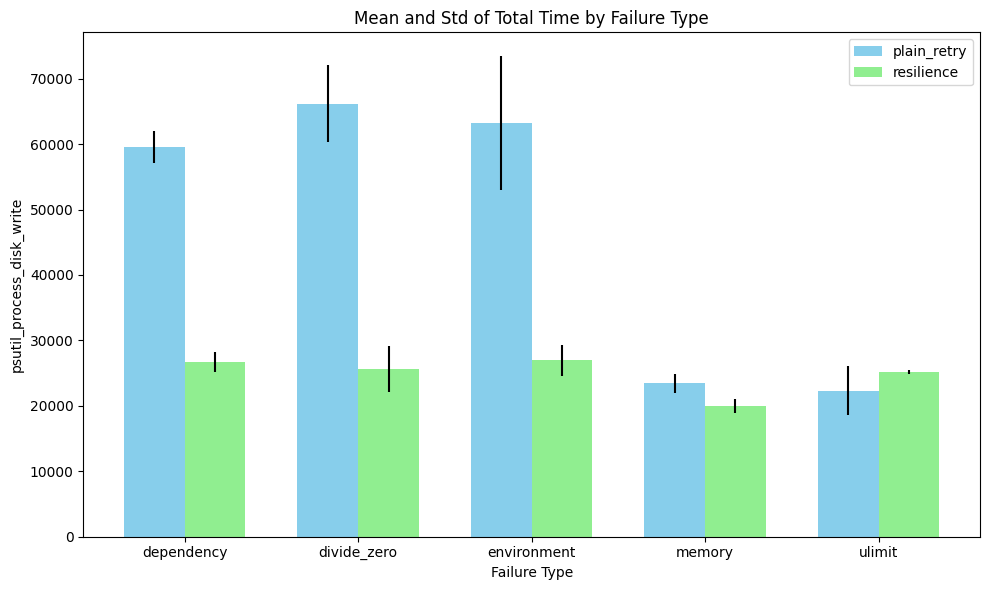

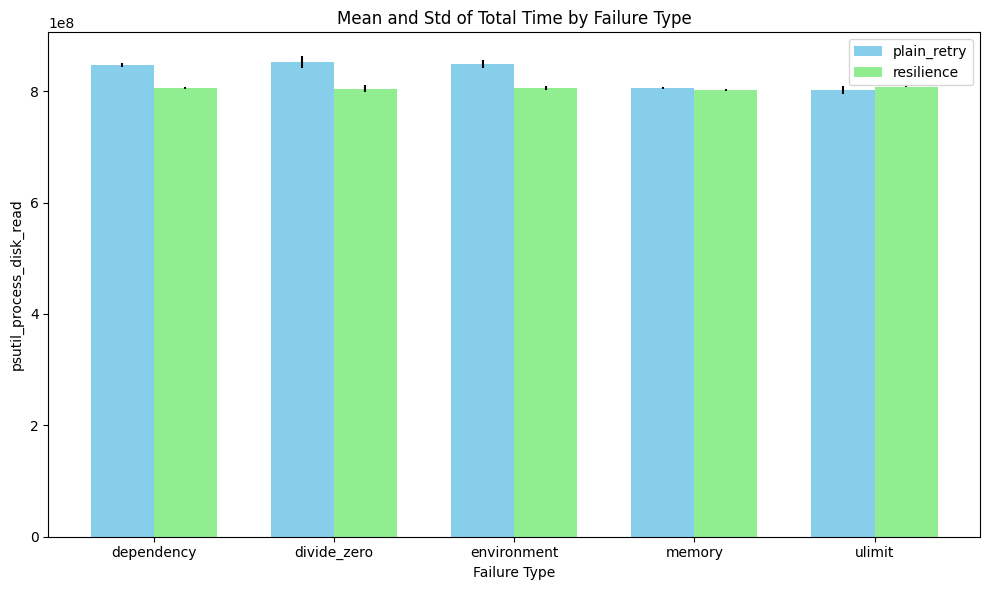

In [17]:
'''
aggregated_dic = {'psutil_process_memory_percent': 1.8277814490970075, 
'psutil_process_memory_virtual': 14785732608, 
'psutil_process_memory_resident': 4936781824, 
'psutil_cpu_count': 8192, 
'psutil_process_disk_write': 42615, 
'psutil_process_disk_read': 818231466, 
'hostname': 'exp-8-52', 
'executor_label': 'htex-1', 
'start_time': 1717169870.1731405}
'''
cal_list = ['psutil_process_memory_percent', 
            'psutil_process_memory_virtual',
            'psutil_process_memory_resident',
            'psutil_cpu_count',
            'psutil_process_disk_write',
            'psutil_process_disk_read']
for name in cal_list:
    draw_resource(name)